In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import VotingRegressor
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import optuna

import warnings
warnings.filterwarnings("ignore")

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#sub = pd.read_csv('sample_submission.csv')

In [3]:
train

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km)
0,1,MITSU,SUV - SMALL,1.5,4.0,AV8,X,8.40 km/L,0.72 L/10km,0.98 L/10km,208
1,2,TOYOTI,PICKUP TRUCK - SMALL,not-available,6.0,A5,X,7.25 km per L,9.70 L/100km,11.96 L/100km,325
2,3,MATSUDA,COMPACT,2.0,4.0,AS6,X,9.80 km/L,38.70 mpg Imp.,31.76 mpg Imp.,170
3,4,CHEVO,VAN - PASSENGER,unknown,8.0,A6,X,1.73 L/10km,11.70 liters per 100 km,14.78 liters per 100 km,362
4,5,TOYOTI,COMPACT,1.8,4.0,M6,X,8.10 L/100km,35.76 mpg Imp.,8.01 liters per 100 km,180
...,...,...,...,...,...,...,...,...,...,...,...
54932,54933,CHEVO,SUBCOMPACT,6.2,8.0,AS10,Z,11.90 L/100km,11.36 km per L,22.39 MPG (AS),318
54933,54934,CHEVO,SUBCOMPACT,3.6,6.0,M6,X,2.10 L/10km,1.06 L/10km,14.41 MPG (AS),303
54934,54935,FOLD,TWO-SEATER,3.5,6.0,AM7,Z,18.20 L/100km,12.50 L/100km,15.63 L/100 km,410
54935,54936,CHEVO,PICKUP TRUCK - STANDARD,6.2,8.0,A8,Z,18.30 L/100 km,9.90 liters per 100 km,14.52 L/100 km,466


In [4]:
test

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb
0,54938,FOLD,PICKUP TRUCK - STANDARD,5.0,8.0,AS10,X,14.20 liters per 100 km,15.20 liters per 100 km,16.06 MPG (AS)
1,54939,BMV,COMPACT,2.0,4.0,A8,Z,9.10 L/100 km,43.46 mpg Imp.,29.66 MPG (AS)
2,54940,JIPU,SUV - SMALL,1.3,4.0,A9,X,27.69 mpg Imp.,7.80 liters per 100 km,9.12 liters per 100 km
3,54941,LECUS,SUV - SMALL,not-recorded,4.0,AS6,Z,NaN,26.43 MPG (AS),NaN
4,54942,BARUSU,COMPACT,2.0,unestablished,M6,Z,11.36 km/L,39.79 mpg Imp.,8.04 L/100km
...,...,...,...,...,...,...,...,...,...,...
23540,78478,MITSU,SUV - SMALL,2.0,4.0,M5,X,NaN,13.33 km/L,8.98 L/100km
23541,78479,CHEVO,COMPACT,1.4,4.0,M6,X,27.04 MPG (AS),18.18 km per L,0.73 L/10km
23542,78480,KIO,SUV - SMALL,unknown,4.0,AS6,X,11.60 L/100km,8.40 liters per 100 km,9.84 km per L
23543,78481,JIPU,SUV - SMALL,2.4,4.0,A9,X,9.52 km/L,0.84 L/10km,0.96 L/10km


In [5]:
def konversi(df, col):
    df[col] = df[col].str.replace(' ', '')
    df[col] = df[col].str.replace('litersper100km', '')
    df[col] = df[col].str.replace('L/100km', '')
    df[col] = df[col].str.replace('L/10km', '*10')#'/10')
    df[col] = df[col].str.replace('MPG(AS)', '**(-1)* 235.21')
    df[col] = df[col].str.replace('km/L', '')#**(-1) /100')
    df[col] = df[col].str.replace('kmperL', '')#'**(-1) /100')
    df[col] = df[col].str.replace('mpgImp.', '**(-1)* 282.48')
    df[col] = df[col].str.replace('not-available', '-1')
    df[col] = df[col].str.replace('zero', '0')
    df[col] = df[col].fillna("-1")
    for idx in df.index:
        df.at[idx, col] = eval(df.at[idx, col])
    df[col] = df[col].astype(float)
    df[col].values[df[col] > 100] = np.nan
    df[col].values[df[col] < 0] = np.nan

In [6]:
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    df[col].values[(df[col] < q1 - 1.5*iqr) | (df[col] > q3 + 1.5*iqr)] = np.nan

In [7]:
konversi(train, 'Fuel Consumption City')
konversi(train, 'Fuel Consumption Hwy')
konversi(train, 'Fuel Consumption Comb')
konversi(test, 'Fuel Consumption City')
konversi(test, 'Fuel Consumption Hwy')
konversi(test, 'Fuel Consumption Comb')

In [8]:
remove_outliers(train, 'Fuel Consumption City')
remove_outliers(train, 'Fuel Consumption Hwy')
remove_outliers(train, 'Fuel Consumption Comb')
remove_outliers(test, 'Fuel Consumption City')
remove_outliers(test, 'Fuel Consumption Hwy')
remove_outliers(test, 'Fuel Consumption Comb')

In [9]:
train['Comb Imputed'] = ~(train['Fuel Consumption City'].isnull()) & ~(train['Fuel Consumption Hwy'].isnull()) & (train['Fuel Consumption Comb'].isnull())
train['City Imputed'] = (train['Fuel Consumption City'].isnull()) & ~(train['Fuel Consumption Hwy'].isnull()) & ~(train['Fuel Consumption Comb'].isnull())
train['Hwy Imputed'] = ~(train['Fuel Consumption City'].isnull()) & (train['Fuel Consumption Hwy'].isnull()) & ~(train['Fuel Consumption Comb'].isnull())

In [10]:
test['Comb Imputed'] = ~(test['Fuel Consumption City'].isnull()) & ~(test['Fuel Consumption Hwy'].isnull()) & (test['Fuel Consumption Comb'].isnull())
test['City Imputed'] = (test['Fuel Consumption City'].isnull()) & ~(test['Fuel Consumption Hwy'].isnull()) & ~(test['Fuel Consumption Comb'].isnull())
test['Hwy Imputed'] = ~(test['Fuel Consumption City'].isnull()) & (test['Fuel Consumption Hwy'].isnull()) & ~(test['Fuel Consumption Comb'].isnull())

In [11]:
train.loc[~(train['Fuel Consumption City'].isnull()) & ~(train['Fuel Consumption Hwy'].isnull()) & (train['Fuel Consumption Comb'].isnull()), 'Fuel Consumption Comb'] = (train['Fuel Consumption City']+train['Fuel Consumption Hwy'])/2
train.loc[(train['Fuel Consumption City'].isnull()) & ~(train['Fuel Consumption Hwy'].isnull()) & ~(train['Fuel Consumption Comb'].isnull()), 'Fuel Consumption City'] = (2*train['Fuel Consumption Comb']-train['Fuel Consumption Hwy'])
train.loc[~(train['Fuel Consumption City'].isnull()) & (train['Fuel Consumption Hwy'].isnull()) & ~(train['Fuel Consumption Comb'].isnull()), 'Fuel Consumption Hwy'] = (2*train['Fuel Consumption Comb']-train['Fuel Consumption City'])

In [12]:
test.loc[~(test['Fuel Consumption City'].isnull()) & ~(test['Fuel Consumption Hwy'].isnull()) & (test['Fuel Consumption Comb'].isnull()), 'Fuel Consumption Comb'] = (test['Fuel Consumption City']+test['Fuel Consumption Hwy'])/2
test.loc[(test['Fuel Consumption City'].isnull()) & ~(test['Fuel Consumption Hwy'].isnull()) & ~(test['Fuel Consumption Comb'].isnull()), 'Fuel Consumption City'] = abs(2*test['Fuel Consumption Comb']-test['Fuel Consumption Hwy'])
test.loc[~(test['Fuel Consumption City'].isnull()) & (test['Fuel Consumption Hwy'].isnull()) & ~(test['Fuel Consumption Comb'].isnull()), 'Fuel Consumption Hwy'] = abs(2*test['Fuel Consumption Comb']-test['Fuel Consumption City'])

In [13]:
train

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km),Comb Imputed,City Imputed,Hwy Imputed
0,1,MITSU,SUV - SMALL,1.5,4.0,AV8,X,8.40,7.200000,9.800000,208,False,False,False
1,2,TOYOTI,PICKUP TRUCK - SMALL,not-available,6.0,A5,X,7.25,9.700000,11.960000,325,False,False,False
2,3,MATSUDA,COMPACT,2.0,4.0,AS6,X,9.80,7.299225,8.894207,170,False,False,False
3,4,CHEVO,VAN - PASSENGER,unknown,8.0,A6,X,17.30,11.700000,14.780000,362,False,False,False
4,5,TOYOTI,COMPACT,1.8,4.0,M6,X,8.10,7.899329,8.010000,180,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54932,54933,CHEVO,SUBCOMPACT,6.2,8.0,AS10,Z,11.90,11.360000,10.505136,318,False,False,False
54933,54934,CHEVO,SUBCOMPACT,3.6,6.0,M6,X,21.00,10.600000,16.322693,303,False,False,False
54934,54935,FOLD,TWO-SEATER,3.5,6.0,AM7,Z,18.20,12.500000,15.630000,410,False,False,False
54935,54936,CHEVO,PICKUP TRUCK - STANDARD,6.2,8.0,A8,Z,18.30,9.900000,14.520000,466,False,False,False


In [14]:
def remove_unknown(df, col):
    for unknown in ['unspecified', 'missing', 'not-available', 'not-recorded', 'unknown', 'unestablished', '-1', 'na']:
        df[col].values[df[col] == unknown] = np.nan

In [15]:
for col in train.columns[2:7]:
    remove_unknown(train, col)
    remove_unknown(test, col)

In [16]:
for col in train.columns:
    print(train[col].unique())

[    1     2     3 ... 54935 54936 54937]
['MITSU' 'TOYOTI' 'MATSUDA' 'CHEVO' 'DOGE' 'BMV' 'LECUS' 'KIO' 'FOLD'
 'JIPU' 'NIRRAN' 'CADILUXE' 'FOLKSWA' 'BARUSU' 'GONDA' 'LAND CRAWLER'
 'RYUNDAI' 'TOLVO' 'FIAR' 'ASURA' 'LAMBOGI']
['SUV - SMALL' 'PICKUP TRUCK - SMALL' 'COMPACT' 'VAN - PASSENGER'
 'MID-SIZE' 'SUV - STANDARD' 'STATION WAGON - SMALL' 'FULL-SIZE'
 'TWO-SEATER' 'PICKUP TRUCK - STANDARD' 'SUBCOMPACT' nan
 'STATION WAGON - MID-SIZE' 'MINICOMPACT' 'MINIVAN'
 'SPECIAL PURPOSE VEHICLE' 'VAN - CARGO']
['1.5' nan '2.0' '1.8' '2.4' '3.5' '2.7' '1.6' '1.2' '2.5' '3.2' '5.0'
 '8.4' '1.4' '3.8' '6.2' '4.4' '3.0' '3.6' '5.7' '5.2' '6.4' '2.3' '3.3'
 '5.3' '6.5' '1.0' '4.0' '3.7' '1.3' '4.6' '4.8' '5.6' '2.8' '6.0' '4.2'
 '4.3' '2.2' '6.6' '5.4' '3.4' '5.8' '6.8']
['4.0' '6.0' '8.0' nan '3.0' '10.0' '12.0' '5.0']
['AV8' 'A5' 'AS6' 'A6' 'M6' 'M5' 'A9' 'AS8' 'AV' 'AM6' 'AS10' 'A8' 'AS9'
 nan 'AM8' 'AM7' 'AV7' 'A4' 'AV6' 'AV10' 'AS5' 'M7' 'A10' 'AS7' 'A7' 'AM9']
['X' 'Z' nan 'E' 'D' 'N']
[ 8.4

In [17]:
train[['TransmisiHuruf', 'TransmisiAngka']] = train['Transmission'].str.extract('([A-Za-z]+)([0-9]+)', expand=True)
test[['TransmisiHuruf', 'TransmisiAngka']] = test['Transmission'].str.extract('([A-Za-z]+)([0-9]+)', expand=True)

In [18]:
train['TransmisiHurufPisah'] = train['TransmisiHuruf'].str[0]
test['TransmisiHurufPisah'] = test['TransmisiHuruf'].str[0]

In [19]:
train

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km),Comb Imputed,City Imputed,Hwy Imputed,TransmisiHuruf,TransmisiAngka,TransmisiHurufPisah
0,1,MITSU,SUV - SMALL,1.5,4.0,AV8,X,8.40,7.200000,9.800000,208,False,False,False,AV,8,A
1,2,TOYOTI,PICKUP TRUCK - SMALL,NaN,6.0,A5,X,7.25,9.700000,11.960000,325,False,False,False,A,5,A
2,3,MATSUDA,COMPACT,2.0,4.0,AS6,X,9.80,7.299225,8.894207,170,False,False,False,AS,6,A
3,4,CHEVO,VAN - PASSENGER,NaN,8.0,A6,X,17.30,11.700000,14.780000,362,False,False,False,A,6,A
4,5,TOYOTI,COMPACT,1.8,4.0,M6,X,8.10,7.899329,8.010000,180,False,False,False,M,6,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54932,54933,CHEVO,SUBCOMPACT,6.2,8.0,AS10,Z,11.90,11.360000,10.505136,318,False,False,False,AS,10,A
54933,54934,CHEVO,SUBCOMPACT,3.6,6.0,M6,X,21.00,10.600000,16.322693,303,False,False,False,M,6,M
54934,54935,FOLD,TWO-SEATER,3.5,6.0,AM7,Z,18.20,12.500000,15.630000,410,False,False,False,AM,7,A
54935,54936,CHEVO,PICKUP TRUCK - STANDARD,6.2,8.0,A8,Z,18.30,9.900000,14.520000,466,False,False,False,A,8,A


In [20]:
test

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,Comb Imputed,City Imputed,Hwy Imputed,TransmisiHuruf,TransmisiAngka,TransmisiHurufPisah
0,54938,FOLD,PICKUP TRUCK - STANDARD,5.0,8.0,AS10,X,14.200000,15.200000,14.645704,False,False,False,AS,10,A
1,54939,BMV,COMPACT,2.0,4.0,A8,Z,9.100000,6.499770,7.930209,False,False,False,A,8,A
2,54940,JIPU,SUV - SMALL,1.3,4.0,A9,X,10.201517,7.800000,9.120000,False,False,False,A,9,A
3,54941,LECUS,SUV - SMALL,NaN,4.0,AS6,Z,NaN,8.899357,NaN,False,False,False,AS,6,A
4,54942,BARUSU,COMPACT,2.0,NaN,M6,Z,11.360000,7.099271,8.040000,False,False,False,M,6,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23540,78478,MITSU,SUV - SMALL,2.0,4.0,M5,X,4.630000,13.330000,8.980000,False,True,False,M,5,M
23541,78479,CHEVO,COMPACT,1.4,4.0,M6,X,8.698595,5.901405,7.300000,False,False,True,M,6,M
23542,78480,KIO,SUV - SMALL,NaN,4.0,AS6,X,11.600000,8.400000,9.840000,False,False,False,AS,6,A
23543,78481,JIPU,SUV - SMALL,2.4,4.0,A9,X,9.520000,8.400000,9.600000,False,False,False,A,9,A


In [21]:
for col in test.columns:
    print(test[col].unique())

[54938 54939 54940 ... 78480 78481 78482]
['FOLD' 'BMV' 'JIPU' 'LECUS' 'BARUSU' 'CHEVO' 'LAND CRAWLER' 'TOLVO'
 'RYUNDAI' 'LAMBOGI' 'KIO' 'TOYOTI' 'ASURA' 'MITSU' 'DOGE' 'CADILUXE'
 'GONDA' 'MATSUDA' 'NIRRAN' 'FOLKSWA' 'FIAR']
['PICKUP TRUCK - STANDARD' 'COMPACT' 'SUV - SMALL' 'TWO-SEATER'
 'SUV - STANDARD' 'MID-SIZE' nan 'FULL-SIZE' 'SUBCOMPACT'
 'STATION WAGON - SMALL' 'VAN - PASSENGER' 'PICKUP TRUCK - SMALL'
 'SPECIAL PURPOSE VEHICLE' 'MINIVAN' 'MINICOMPACT' 'VAN - CARGO'
 'STATION WAGON - MID-SIZE']
['5.0' '2.0' '1.3' nan '6.2' '1.8' '4.4' '1.6' '2.4' '3.0' '1.4' '6.0'
 '5.2' '3.5' '3.3' '2.5' '2.3' '3.2' '3.6' '3.8' '1.0' '4.8' '2.8' '2.7'
 '5.6' '1.5' '5.3' '5.8' '6.6' '5.7' '6.4' '8.4' '4.6' '5.4' '3.7' '4.0'
 '1.2' '4.3' '6.5' '3.4' '6.8' '2.2' '4.2']
['8.0' '4.0' nan '10.0' '6.0' '3.0' '12.0' '5.0']
['AS10' 'A8' 'A9' 'AS6' 'M6' 'M7' 'AS8' 'A6' 'AM7' 'M5' 'AS9' 'AV7' 'AV6'
 nan 'AV' 'AM6' 'A5' 'AS7' 'A4' 'AV8' 'AS5' 'A10' 'AM8' 'AV10' 'AM9' 'A7']
['X' 'Z' 'D' nan 'E' 'N']
[14.2

In [22]:
for col in train.columns:
    print(train[col].unique())

[    1     2     3 ... 54935 54936 54937]
['MITSU' 'TOYOTI' 'MATSUDA' 'CHEVO' 'DOGE' 'BMV' 'LECUS' 'KIO' 'FOLD'
 'JIPU' 'NIRRAN' 'CADILUXE' 'FOLKSWA' 'BARUSU' 'GONDA' 'LAND CRAWLER'
 'RYUNDAI' 'TOLVO' 'FIAR' 'ASURA' 'LAMBOGI']
['SUV - SMALL' 'PICKUP TRUCK - SMALL' 'COMPACT' 'VAN - PASSENGER'
 'MID-SIZE' 'SUV - STANDARD' 'STATION WAGON - SMALL' 'FULL-SIZE'
 'TWO-SEATER' 'PICKUP TRUCK - STANDARD' 'SUBCOMPACT' nan
 'STATION WAGON - MID-SIZE' 'MINICOMPACT' 'MINIVAN'
 'SPECIAL PURPOSE VEHICLE' 'VAN - CARGO']
['1.5' nan '2.0' '1.8' '2.4' '3.5' '2.7' '1.6' '1.2' '2.5' '3.2' '5.0'
 '8.4' '1.4' '3.8' '6.2' '4.4' '3.0' '3.6' '5.7' '5.2' '6.4' '2.3' '3.3'
 '5.3' '6.5' '1.0' '4.0' '3.7' '1.3' '4.6' '4.8' '5.6' '2.8' '6.0' '4.2'
 '4.3' '2.2' '6.6' '5.4' '3.4' '5.8' '6.8']
['4.0' '6.0' '8.0' nan '3.0' '10.0' '12.0' '5.0']
['AV8' 'A5' 'AS6' 'A6' 'M6' 'M5' 'A9' 'AS8' 'AV' 'AM6' 'AS10' 'A8' 'AS9'
 nan 'AM8' 'AM7' 'AV7' 'A4' 'AV6' 'AV10' 'AS5' 'M7' 'A10' 'AS7' 'A7' 'AM9']
['X' 'Z' nan 'E' 'D' 'N']
[ 8.4

<Axes: xlabel='Fuel Consumption City'>

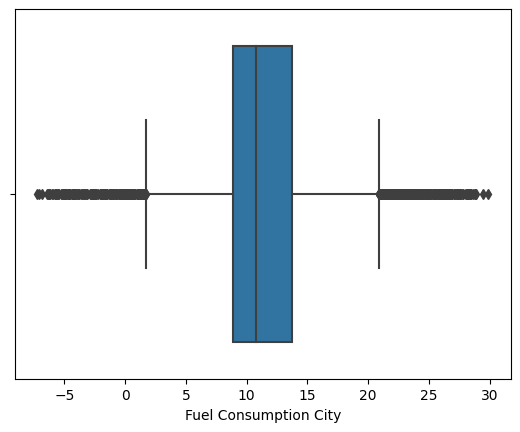

In [23]:
import seaborn as sns

sns.boxplot(data=train, x='Fuel Consumption City')


In [26]:
train[train['City Imputed'] == True]['Fuel Consumption City'].describe()

count    2622.000000
mean       11.671498
std         7.345489
min        -7.220000
25%         6.832500
50%        11.300388
75%        16.458679
max        29.900000
Name: Fuel Consumption City, dtype: float64

<Axes: ylabel='Density'>

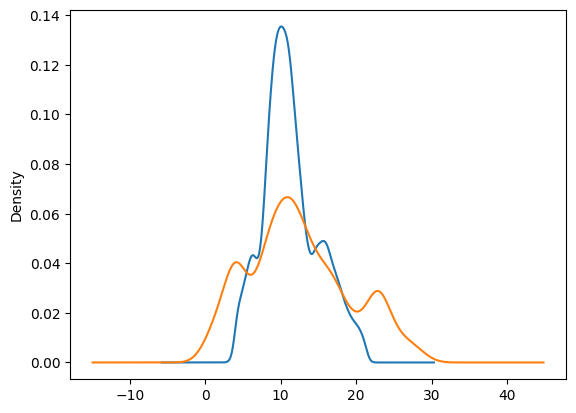

In [49]:
city_asli = train[train['City Imputed'] == False]['Fuel Consumption City']
city_imputed = train[train['City Imputed'] == True]['Fuel Consumption City']
city_asli.plot(kind='kde')
city_imputed.plot(kind='kde')



<Axes: ylabel='Density'>

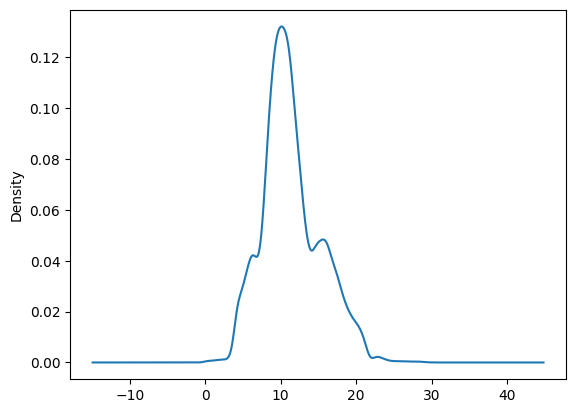

In [55]:
train['Fuel Consumption City'].plot(kind='kde')

In [54]:
train[train['City Imputed']]

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km),Comb Imputed,City Imputed,Hwy Imputed,TransmisiHuruf,TransmisiAngka,TransmisiHurufPisah
6,7,BMV,COMPACT,2.0,NaN,M6,Z,9.087709,8.10000,8.593855,201,False,True,False,M,6,M
21,22,NIRRAN,STATION WAGON - SMALL,1.6,4.0,M6,Z,13.199976,9.71000,11.454988,187,False,True,False,M,6,M
41,42,KIO,STATION WAGON - MID-SIZE,2.0,4.0,A6,X,11.280000,8.20000,9.740000,200,False,True,False,A,6,A
63,64,LAMBOGI,TWO-SEATER,5.2,10.0,AM7,Z,3.760000,5.92000,4.840000,371,False,True,False,AM,7,A
71,72,DOGE,SUV - SMALL,3.6,6.0,A6,E,7.860000,10.30000,9.080000,262,False,True,False,A,6,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54793,54794,KIO,COMPACT,1.6,4.0,AS6,NaN,10.610000,10.99000,10.800000,225,False,True,False,AS,6,A
54802,54803,GONDA,MID-SIZE,NaN,6.0,M6,X,13.362577,8.30000,10.831288,251,False,True,False,M,6,M
54809,54810,CHEVO,NaN,5.3,NaN,A6,E,22.701370,12.89863,17.800000,346,False,True,False,A,6,A
54891,54892,FOLD,PICKUP TRUCK - STANDARD,3.5,6.0,AS6,NaN,13.487810,10.31000,11.898905,338,False,True,False,AS,6,A


<Axes: ylabel='Density'>

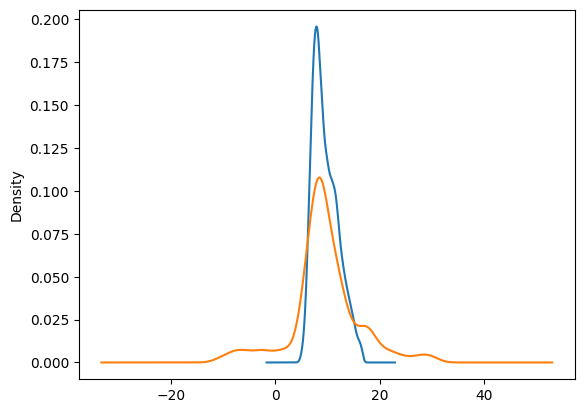

In [28]:
Hwy_asli = train[train['Hwy Imputed'] == False]['Fuel Consumption Hwy']
Hwy_imputed = train[train['Hwy Imputed'] == True]['Fuel Consumption Hwy']
Hwy_asli.plot(kind='kde')
Hwy_imputed.plot(kind='kde')

<Axes: ylabel='Density'>

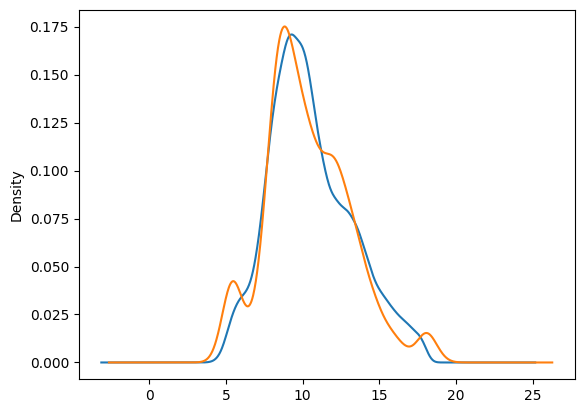

In [29]:
Comb_asli = train[train['Comb Imputed'] == False]['Fuel Consumption Comb']
Comb_imputed = train[train['Comb Imputed'] == True]['Fuel Consumption Comb']
Comb_asli.plot(kind='kde')
Comb_imputed.plot(kind='kde')

In [33]:
city_asli.describe()

count    51529.000000
mean        11.372061
std          3.691270
min          3.280000
25%          8.930000
50%         10.800000
75%         13.595954
max         21.305254
Name: Fuel Consumption City, dtype: float64

In [34]:
city_imputed.describe()

count    2622.000000
mean       11.671498
std         7.345489
min        -7.220000
25%         6.832500
50%        11.300388
75%        16.458679
max        29.900000
Name: Fuel Consumption City, dtype: float64

In [35]:
Hwy_asli.describe()

count    51603.000000
mean         9.618072
std          2.422124
min          4.500000
25%          7.700000
50%          9.100000
75%         11.240000
max         16.804283
Name: Fuel Consumption Hwy, dtype: float64

In [36]:
Hwy_imputed.describe()

count    2726.000000
mean        9.543865
std         6.602880
min       -11.740000
25%         7.025000
50%         8.981724
75%        12.158960
max        31.510000
Name: Fuel Consumption Hwy, dtype: float64

In [42]:
train.loc[~(train['City Imputed']) & ~(train['Hwy Imputed']) & (train['Comb Imputed']), 'Fuel Consumption Comb'] = (11*train['Fuel Consumption City']+9*train['Fuel Consumption Hwy'])/20
train.loc[(train['City Imputed']) & ~(train['Hwy Imputed']) & (train['Comb Imputed']), 'Fuel Consumption City'] = (20*train['Fuel Consumption Comb']-9*train['Fuel Consumption Hwy'])/11
train.loc[~(train['City Imputed']) & (train['Hwy Imputed']) & (train['Comb Imputed']), 'Fuel Consumption Hwy'] = (20*train['Fuel Consumption Comb']-11*train['Fuel Consumption City'])/9

In [48]:
train['Fuel Consumption City'].values[train['Fuel Consumption City'] < 0] = np.nan
train['Fuel Consumption Hwy'].values[train['Fuel Consumption Hwy'] < 0] = np.nan
test['Fuel Consumption City'].values[test['Fuel Consumption City'] < 0] = np.nan
test['Fuel Consumption Hwy'].values[test['Fuel Consumption Hwy'] < 0] = np.nan

<Axes: >

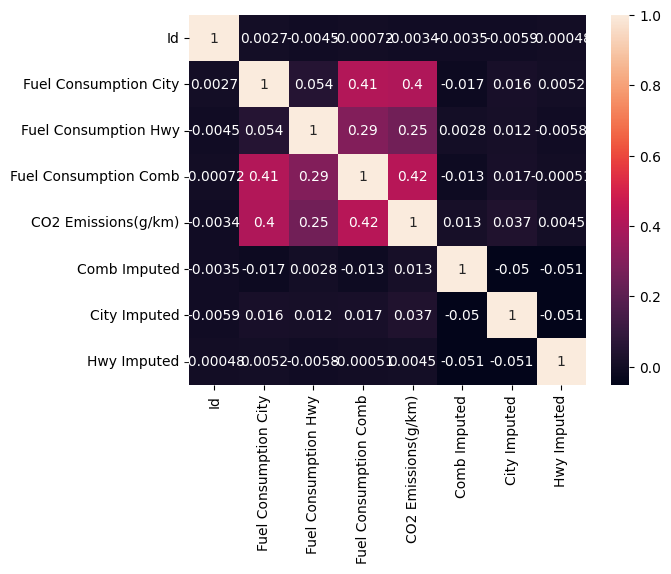

In [38]:
sns.heatmap(train.corr(numeric_only=True), annot=True)

In [59]:
train.loc[train['City Imputed'], 'Fuel Consumption City'] = train.groupby('Vehicle Class')['Fuel Consumption City'].transform('median')
train.loc[train['Hwy Imputed'], 'Fuel Consumption Hwy'] = train.groupby('Vehicle Class')['Fuel Consumption Hwy'].transform('median')

In [58]:
train.columns

Index(['Id', 'Make', 'Vehicle Class', 'Engine Size(L)', 'Cylinders',
       'Transmission', 'Fuel Type', 'Fuel Consumption City',
       'Fuel Consumption Hwy', 'Fuel Consumption Comb', 'CO2 Emissions(g/km)',
       'Comb Imputed', 'City Imputed', 'Hwy Imputed', 'TransmisiHuruf',
       'TransmisiAngka', 'TransmisiHurufPisah'],
      dtype='object')

In [60]:
test.loc[test['City Imputed'], 'Fuel Consumption City'] = test.groupby('Vehicle Class')['Fuel Consumption City'].transform('median')
test.loc[test['Hwy Imputed'], 'Fuel Consumption Hwy'] = test.groupby('Vehicle Class')['Fuel Consumption Hwy'].transform('median')

<Axes: ylabel='Density'>

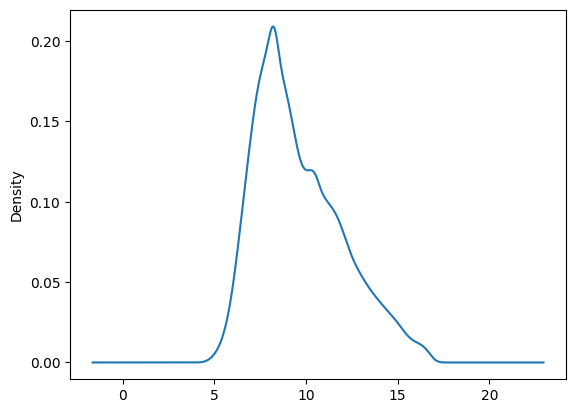

In [64]:
train['Fuel Consumption Hwy'].plot(kind='kde')

<Axes: ylabel='Density'>

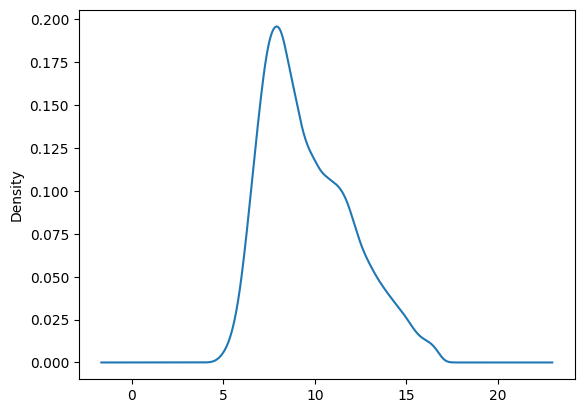

In [65]:
train[train['Hwy Imputed'] == False]['Fuel Consumption Hwy'].plot(kind='kde')

In [68]:
train.isna().sum()

Id                          0
Make                        0
Vehicle Class            2051
Engine Size(L)           5264
Cylinders                4523
Transmission             1483
Fuel Type                1942
Fuel Consumption City     888
Fuel Consumption Hwy      709
Fuel Consumption Comb     940
CO2 Emissions(g/km)         0
Comb Imputed                0
City Imputed                0
Hwy Imputed                 0
TransmisiHuruf           4646
TransmisiAngka           4646
TransmisiHurufPisah      4646
dtype: int64

In [70]:
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)


In [72]:
train.to_csv('train_baru.csv', index=False)
test.to_csv('test_baru.csv', index=False)